# Chapter 2. Smoothing filters

Ildar Rakhmatulin ildarr2016@gmail.com

## Import libraries

To install libraries in Python, you can use a package manager like pip, which comes pre-installed with most Python distributions.



In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy import signal

## Import Dataset

Load dataset
https://github.com/Ildaron/ironbci  
The following dataset structure is used  


ch1	ch2	ch3	ch4	ch5	ch6	ch7	ch8  
..    ..    ..  ..  ..  ..  ..  ..    
..    ..    ..  ..  ..  ..  ..  ..  

In [4]:
# load the Excel file as a DataFrame
eeg_data = pd.read_excel("https://github.com/rklymentiev/EEG_course/raw/master/dataset/dataset.xlsx")
display(eeg_data.head())

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,23899.1,2951.1,36442.2,38418.6,12414.9,3759.5,31001.4,52775.3
1,23917.7,3048.0,36463.8,38344.3,12448.1,3726.3,31032.4,52223.4
2,23984.9,3148.2,36525.1,39002.6,12520.4,3601.3,31103.2,53175.1
3,24016.8,3183.3,36551.5,39602.8,12548.5,3473.0,31133.2,54514.6
4,23960.3,3061.0,36494.8,39256.9,12475.6,3549.7,31061.9,54321.3


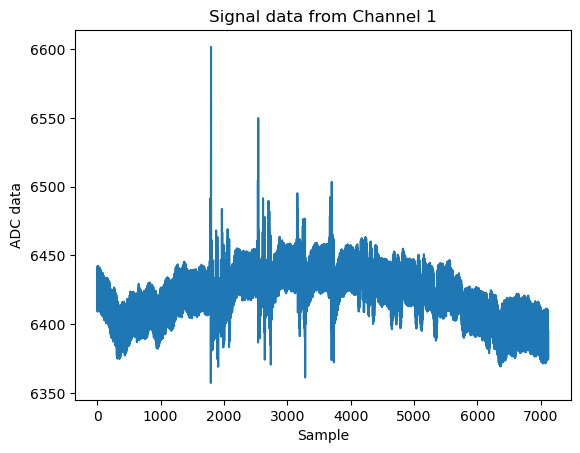

In [3]:
# select the data from the first channel
channel = 0
channel_data = eeg_data.iloc[:, channel]
channel_data = round(1000000*4.5*(channel_data/16777215),2)  # ???

# plot the EEG data
plt.plot(channel_data)
plt.title("Signal data from Channel 1")
plt.ylabel('ADC data')  # ADC = ???
plt.xlabel('Sample')
plt.show()

## Band Pass Filter

Band-pass filtering is a common signal processing technique used in EEG (Electroencephalography) data analysis to isolate specific frequency bands of interest while removing unwanted frequencies. Band-pass filtering allows researchers to focus on particular brainwave rhythms that are relevant to their study. For example, you might want to extract the alpha, beta, or gamma waves from the EEG data.  


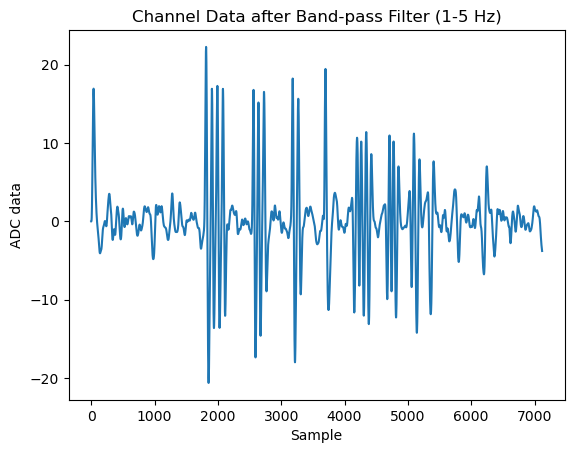

In [17]:
def butter_highpass_filter(data, cutoff, nyq, order=5):
    """Butterworth high-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def butter_lowpass_filter(data, cutoff, nyq, order=5):
    """Butterworth low-pass filter.
    Args:
        data (array_like): data to be filtered.
        cutoff (float): cutoff frequency.
        order (int): order of the filter.
    Returns:
        array: filtered data."""
    normal_cutoff = cutoff / nyq  # normalized cutoff frequency
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

channel_data_bp_filtered = channel_data.copy()  # copy the data
fps = 250  # sampling frequency 
cutoff_high = 1  # cutoff frequency of the high-pass filter
cutoff_low = 5  # cutoff frequency of the low-pass filter
nyq = 0.5 * fps  # Nyquist frequency (half of the sampling frequency)

# apply the band-pass filter
channel_data_bp_filtered = butter_highpass_filter(
    data=channel_data_bp_filtered, 
    cutoff=cutoff_high, 
    nyq=nyq,
    order=5)
channel_data_bp_filtered = butter_lowpass_filter(
    data=channel_data_bp_filtered, 
    cutoff=cutoff_low, 
    nyq=nyq,
    order=4)

plt.plot(channel_data_bp_filtered)
plt.title("Channel Data after Band-pass Filter (1-5 Hz)")
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.show()

## Smoothing filters
Smoothing filters are essential tools in EEG signal processing, used to reduce noise and highlight underlying patterns. These filters work by averaging or weighting neighboring data points to create a smoother representation of the signal. The average filter computes the mean of nearby samples, reducing high-frequency noise.

## Average filter

In signal processing of EEG (Electroencephalography) data, calculating the average is a common technique used to improve the signal-to-noise ratio and highlight underlying brain activity. The EEG signal is often contaminated with noise and artifacts, and averaging can help reduce these unwanted components while preserving the brain-related activity.   

**Positive**  

* An average filter can effectively smooth out the EEG signal by removing high-frequency noise and minor fluctuations.
* Easy to implement
* EEG signals often exhibit slow oscillatory patterns, such as alpha, beta, and delta waves. Applying an average filter with a longer time window can help visualize these slower frequency components by attenuating faster fluctuations

**Negative**

* Temporal Resolution. Applying an average filter with a large window can smooth out fine temporal details and fast changes in the EEG signal. Depending on your analysis goals, this may or may not be desirable.

* Signal Distortion. Over-smoothing can lead to the loss of important signal features, including transient responses or rapid changes that might be critical for your analysis.

* Baseline Fluctuations. If analysis involves comparing EEG activity before and after specific events, excessive smoothing can reduce the detectable differences in baseline fluctuations.

**How it works**  

An average filter for EEG works by smoothing out the signal by replacing each data point with the average value of neighboring data points within a defined window. Need to choose an appropriate window size to balance noise reduction with preserving important signal features.

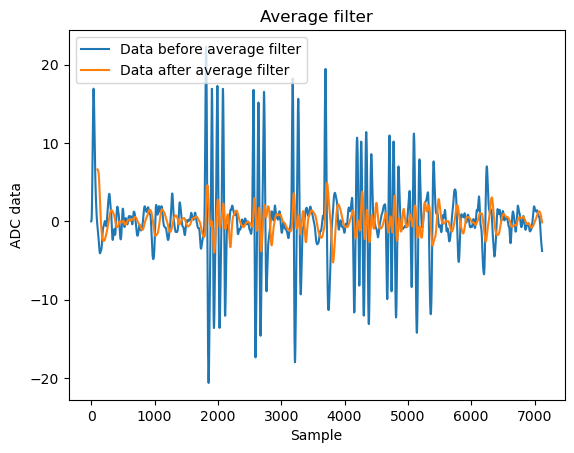

In [35]:
def average_filter(data, average_length):
    """
    
    :param data: 
    :param average_length: 
    :return: 
    """
    data = pd.DataFrame(data)
    avereged_data = data.rolling(window=average_length).mean()
    return avereged_data

average_length = 100
channel_data_avg = average_filter(data=channel_data_bp_filtered, average_length=average_length)

plt.title("Average filter")
plt.plot(channel_data_bp_filtered, label='Data before average filter')
plt.plot(channel_data_avg, label='Data after average filter')
plt.ylabel('ADC data')
plt.xlabel('Sample')
plt.legend(loc='upper left')
plt.show()

## Gaussian Filter

Applying a Gaussian filter to EEG data is a signal processing technique commonly used for smoothing or denoising the signals. Gaussian filtering is a linear smoothing filter that uses a Gaussian kernel to convolve with the EEG signal, effectively reducing noise and emphasizing underlying trends or features.  

**Positive**  

* Noise Smoothing. Gaussian filters smooth out noise in the EEG signal, helping to reduce random fluctuations caused by artifacts and environmental interference.
* Preserving Temporal Details. Unlike simple moving average filters, Gaussian filters preserve finer temporal features by attenuating noise while maintaining sharp signal transitions.
* Event-Related Potentials (ERPs). Gaussian filters are well-suited for enhancing ERP components, such as P300 responses, by reducing noise without distorting the underlying event-related activity.
* Spatial Smoothing. For EEG recordings with multiple electrodes (scalp channels), Gaussian filters can be applied across neighboring channels to improve signal-to-noise ratio and reveal broader neural patterns.
* Frequency-Selective Smoothing. By adjusting the width of the Gaussian kernel, is ir possibly selectively smooths specific frequency ranges in the EEG signal, making it useful for targeting noise reduction in certain frequency bands.

**Negative**

* Kernel Size. The width of the Gaussian kernel (often determined by the standard deviation) impacts the amount of smoothing. Smaller standard deviations preserve more detail, while larger values provide more smoothing.
* Signal Distortion. Excessive smoothing can blur rapid changes and transient responses, potentially masking important features in the EEG data.
* Artifact Handling. While Gaussian filters can reduce random noise, they might not be as effective at removing structured artifacts like muscle artifacts. Additional preprocessing steps might be needed.
* Parameter Selection. The choice of kernel size (standard deviation) depends on your specific analysis goals and the characteristics of your EEG data. Experimentation and validation are crucial.

**How it works** 
   
A Gaussian filter for EEG works by convolving the EEG signal with a Gaussian-shaped curve. This curve assigns more weight to nearby data points and gradually decreases the weight as distance from the center increases.  The width of the Gaussian curve, controlled by its standard deviation, determines the level of smoothing: smaller standard deviations maintain fine details, while larger values yield more smoothing. This makes Gaussian filters suitable for enhancing event-related potentials and reducing noise while retaining temporal precision.

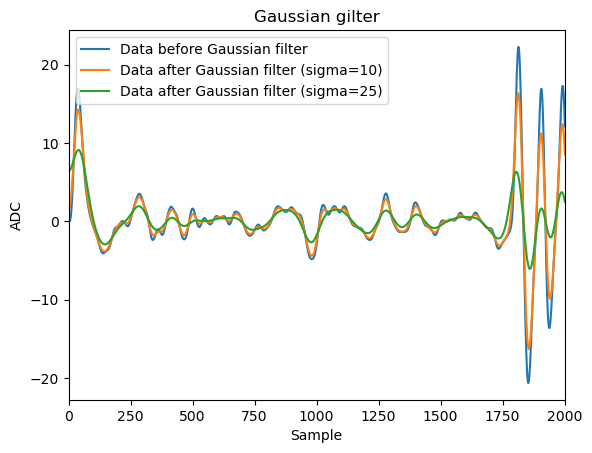

In [27]:
from scipy.ndimage import gaussian_filter1d

channel_data_gauss_25 = gaussian_filter1d(channel_data_bp_filtered, sigma=25)
channel_data_gauss_10 = gaussian_filter1d(channel_data_bp_filtered, sigma=10)

# plot the data
plt.title("Gaussian gilter")
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.plot(channel_data_bp_filtered, label='Data before Gaussian filter')
plt.plot(channel_data_gauss_10, label='Data after Gaussian filter (sigma=10)')
plt.plot(channel_data_gauss_25, label='Data after Gaussian filter (sigma=25)')
plt.legend(loc='upper left')
plt.xlim([0, 2000])  # zoom in the data
plt.show()

## Median filter

Using the median filter for EEG data is another signal processing technique that can be useful for denoising and removing outliers. The median filter replaces each data point with the median value within its neighboring window, which is effective in reducing random noise while preserving sharp edges or features in the signal.  

**Positive**  

* Artifact Removal: Median filters are effective at removing transient artifacts like spikes and sharp fluctuations caused by muscle activity or electrode movement. They're particularly adept at preserving the integrity of the original signal during artifact removal.
* Impulsive Noise: EEG recordings can be affected by impulsive noise that causes isolated extreme values. Median filters are excellent at suppressing these isolated outliers without altering the rest of the signal.
* Preserving Features: Unlike some smoothing filters, median filters do not excessively blur or distort sharp features such as event-related potentials (ERPs) or transient neural responses.
*  Baseline Correction: Median filters can be used for baseline correction, especially in cases where the baseline exhibits sudden variations.

**Negative**

* Smoothing: Median filters are not well-suited for smoothing continuous, gradual changes in EEG signals. They are designed to remove isolated outliers and sharp transients, so they may not effectively address slowly varying noise or baseline drift.
* Frequency-Specific Analysis: Median filters are not frequency-selective like band-pass filters. If you are specifically interested in analyzing frequency components of the EEG signal, using a median filter could distort these components.
* Event-Related Potentials (ERPs): While median filters can preserve sharp features, they might not be suitable for enhancing ERPs, as ERPs often require specialized preprocessing methods that maintain the temporal integrity of the responses.
* Signal Distortion: Median filters can cause signal distortion, especially if the filter's window size is too large. This distortion can impact the shape and timing of certain EEG components.
* Edge Effects: Median filters can introduce artifacts at the edges of the data, affecting the beginning and end of the filtered signal. Proper handling of these edge effects is essential.
* Baseline Drift: Median filters might not effectively remove slow baseline drifts, which require different techniques such as polynomial fitting or high-pass filtering.
* Non-Impulsive Noise: Median filters are most effective against impulsive noise. If the noise in your EEG signal is not primarily impulsive, other filtering methods might be more appropriate.

**How it works**  

A median filter for EEG works by replacing each data point in the signal with the median value of neighboring data points within a defined window. This process effectively reduces isolated spikes, impulsive noise, and sharp transients in the signal while preserving the integrity of sharp features.


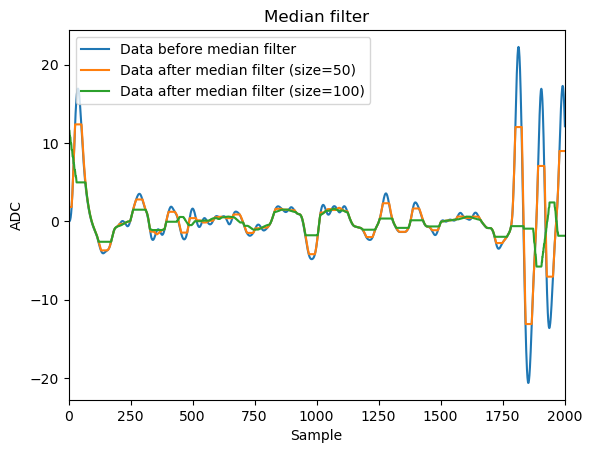

In [34]:
from scipy import ndimage

channel_data_median_100 = ndimage.median_filter(channel_data_bp_filtered, size=100)
channel_data_median_50 = ndimage.median_filter(channel_data_bp_filtered, size=50)

# plot the data
plt.title("Median filter")
plt.xlabel("Sample")
plt.ylabel("ADC")
plt.plot(channel_data_bp_filtered, label='Data before median filter')
plt.plot(channel_data_median_50, label='Data after median filter (size=50)')
plt.plot(channel_data_median_100, label='Data after median filter (size=100)')
plt.legend(loc='upper left')
plt.xlim([0, 2000])  # zoom in the data
plt.show()